# TEST AB

1. [WEB DATA](#1-web_data)
2. [SM DATA](#2-sm-data)
3. [LP DATA](#3-lp-data)

In [1]:
# Importamos las librerías necesarias
import pandas as pd; pd.set_option('display.max_columns', None) # Tratamiento de datos
import matplotlib.pyplot as plt # Visualización
import seaborn as sns
from src import soporte_abtesting as sa
import warnings; warnings.filterwarnings("ignore") # Para ignorar los warnings.

from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

# 1. Web_data

## 1.1 Lectura de datos

In [2]:
# Cargamos el conjunto de datos
df_web = pd.read_csv('Datos/web_data.csv')
df_web.sample(5)

,page_version,session_duration,bounce_rate,conversion_rate
39,A,293.096025,0.343039,0.068503
74,B,347.930067,0.327327,0.071257
98,B,413.356623,0.301840,0.065091
53,A,269.615960,0.349371,0.063041
3,A,291.352460,0.308925,0.083441


## 1.2 Breve exploración de los datos

In [3]:
# Mostramos la información general del df_web
df_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_version      110 non-null    object 
 1   session_duration  110 non-null    float64
 2   bounce_rate       110 non-null    float64
 3   conversion_rate   110 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.6+ KB


In [4]:
# Breve exploración 
df_web.describe().T

,count,mean,std,min,25%,50%,75%,max
session_duration,110.0,311.718698,41.756119,216.745985,285.116278,309.512565,341.416845,413.356623
bounce_rate,110.0,0.285084,0.048116,0.200471,0.246359,0.289800,0.324121,0.397070
conversion_rate,110.0,0.077199,0.019128,0.044756,0.062496,0.072267,0.092395,0.119904


In [5]:
# Exploración básica del df
sa.exploracion_dataframe(df_web, 'page_version')

El número de datos es 110 y el de columnas es 4

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
page_version,object
session_duration,float64
bounce_rate,float64
conversion_rate,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna PAGE_VERSION tiene las siguientes valore únicos:


,count
page_version,
A,55
B,55



 ..................... 

Los principales estadísticos de las columnas categóricas para el A son: 


,count,unique,top,freq
page_version,55,1,A,55



 ..................... 

Los principales estadísticos de las columnas numéricas para el A son: 


,count,mean,std,min,25%,50%,75%,max
session_duration,55.0,304.243138,44.036204,216.745985,281.055692,297.047708,334.760486,393.473388
bounce_rate,55.0,0.290064,0.053722,0.200471,0.247088,0.297050,0.328625,0.397070
conversion_rate,55.0,0.071229,0.015793,0.044756,0.057858,0.069649,0.084408,0.098960



 ..................... 

Los principales estadísticos de las columnas categóricas para el B son: 


,count,unique,top,freq
page_version,55,1,B,55



 ..................... 

Los principales estadísticos de las columnas numéricas para el B son: 


,count,mean,std,min,25%,50%,75%,max
session_duration,55.0,319.194258,38.293738,244.287849,289.674048,321.640974,344.876807,413.356623
bounce_rate,55.0,0.280104,0.041674,0.206448,0.245338,0.288822,0.315654,0.346803
conversion_rate,55.0,0.083168,0.020408,0.051426,0.066465,0.080247,0.102651,0.119904


In [6]:
# Agrupamos 'page_version' devolviendo los estadísticos de media y desviación estándar
ratio_conversion = df_web.groupby('page_version')['conversion_rate'].agg(['mean','std']).round(4)
print(ratio_conversion)

                mean     std
page_version                
A             0.0712  0.0158
B             0.0832  0.0204


Aunque la tasa de conversión de la página B es mayor que la página A, las desviaciones estándar muestran que hay más variabilidad en los datos en la versión B. Una mayor variabilidad puede llevarnos a una mayor incertidumbre.

## 1.3 Visualización

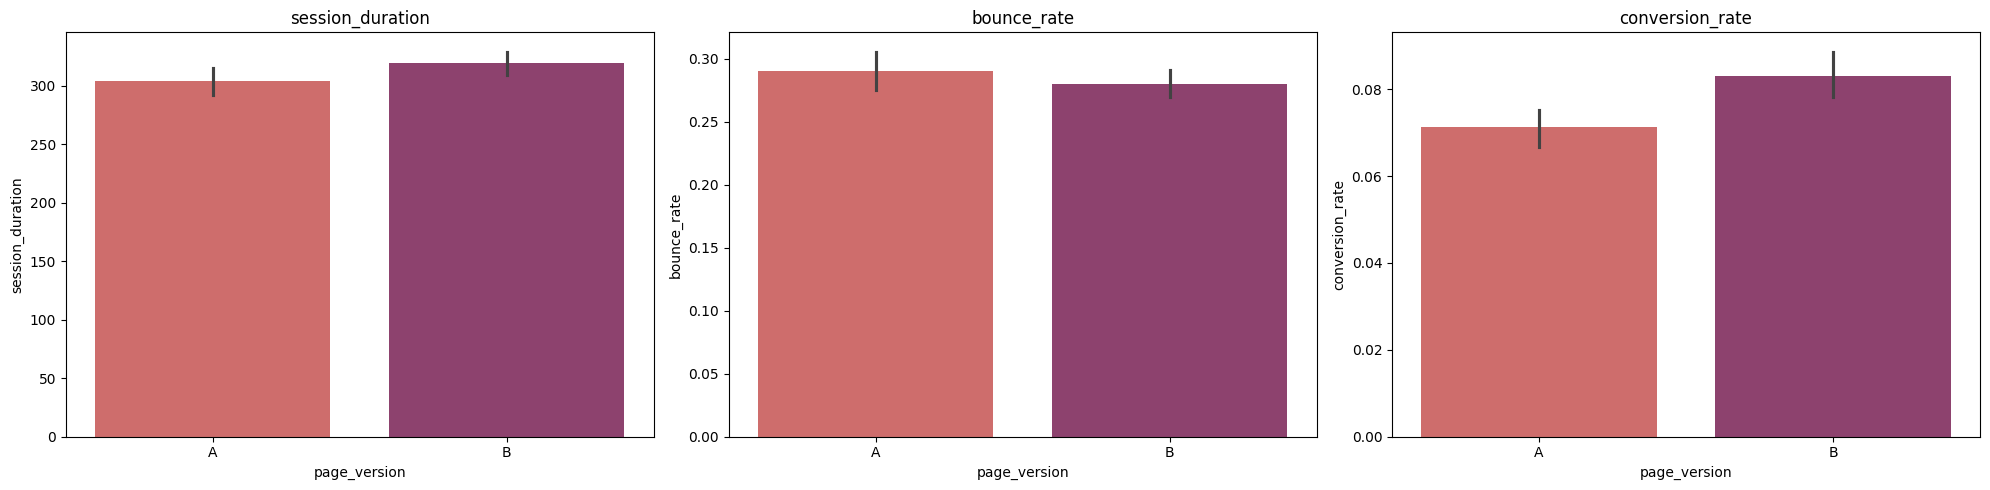

In [7]:
# Mostramos un gráfico de barras para ver las diferentes métricas según la versión de la página:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) # Creamos subgráficos.
columnas_graficas = ["session_duration", "bounce_rate", "conversion_rate"] # Creamos una lista con las variables numéricas que queremos incluir en las gráficas.

for indice, columna in enumerate(columnas_graficas):
    sns.barplot(x="page_version", y=columna, data=df_web, ax=axes[indice], palette="flare") # Creamos un barplot para nuestras gráficas.
    axes[indice].set_title(columna) # Ponemos título a las gráficas.

plt.tight_layout();

## 1.4 Formulación de hipótesis

- **Efecto de la nueva versión de la página:** En este caso las hipótesis serían: 

    - $H0$: La versión B de la web no tiene un impacto significativo respecto a la versión A.

    - $H1$: La versión B de la web tiene un impacto significativo respecto a la versión A. 

## 1.5 Prueba estadística

In [8]:
# Lista de métricas
metricas = ["session_duration", "bounce_rate", "conversion_rate"]

In [9]:
grupos = df_web["page_version"].unique()

**Prueba de normalidad (Shapiro-Wilk)**

In [10]:
# Evaluamos normalidad para cada grupo
for metrica in metricas: 
    for grupo in grupos: 
        print(f"Estamos analizando la variable {metrica.upper()} para la página {grupo.upper()}")
        df_normalidad = df_web[df_web["page_version"] == grupo]
        test_asunciones = sa.Asunciones(dataframe = df_normalidad, columna_numerica = metrica)
        test_asunciones.identificar_normalidad_analitica() # Comprobamos la asunción de normalidad, como tenemos menos de 50 datos por grupo, usaremos un shapiro test.
        print("\n-------------\n")

Estamos analizando la variable SESSION_DURATION para la página A
Para la columna session_duration, los datos siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable SESSION_DURATION para la página B
Para la columna session_duration, los datos siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable BOUNCE_RATE para la página A
Para la columna bounce_rate, los datos siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable BOUNCE_RATE para la página B
Para la columna bounce_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable CONVERSION_RATE para la página A
Para la columna conversion_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable CONVERSION_RATE para la página B
Para la columna c

<div style="background-color: #F74646; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Los principales resultados de los análisis de normalidad son:</h5>

1. **SESSION_DURATION**:

   - **Página A**: la variable SESSION_DURATION sigue una distribución normal.

   - **Página B**: la variable SESSION_DURATION sigue una distribución normal.

2. **BOUNCE_RATE**:

   - **Página A**: la variable BOUNCE_RATE sigue una distribución normal.

   - **Página B**: la variable BOUNCE_RATE no sigue una distribución normal.

3. **CONVERSION_RATE**:

   - **Página A**: la variable CONVERSION_RATE no sigue una distribución normal.

   - **Página B**: la variable CONVERSION_RATE no sigue una distribución normal.

De estos resultados podemos concluir que:

1. **SESSION_DURATION**: dado que la variable SESSION_DURATION sigue una distribución normal en ambas versiones, cumplen las asunciones de normalidad y tenemos que comprobar las asunciones de homocedasticidad.

2. **BOUNCE_RATE y CONVERSION_RATE**: ambas variables no siguen una distribución normal, salvo la página A en la variable BOUNCE_RATE. Esto indica claramente que las asunciones de normalidad no se cumplen para estas variables. Por consiguiente, las pruebas paramétricas no serían adecuadas para analizar estas variables.

</div>

**Prueba de homocedasticidad**

In [11]:
# Evaluamos homocedasticidad para SESSION_DURATION
metricas_homo = ['session_duration']
for metrica in metricas_homo: 
    for grupo in grupos: 
        print(f"Estamos analizando la variable {metrica.upper()} para la página {grupo.upper()}")
        df_homocedasticidad = df_web[df_web["page_version"] == grupo]
        test_asunciones = sa.Asunciones(dataframe = df_homocedasticidad, columna_numerica = metrica)
        test_asunciones.identificar_homogeneidad(metrica) # Comprobamos la asunción de homocedasticidad

Estamos analizando la variable SESSION_DURATION para la página A
En la variable session_duration las varianzas NO son homogéneas entre grupos.
Estamos analizando la variable SESSION_DURATION para la página B
En la variable session_duration las varianzas NO son homogéneas entre grupos.


Al no cumplir con la asunción de homocedasticidad en la variable SESSION_DURATION, optamos por realizar un test no paramétrico para todas las variables. En concreto, vamos a utilizar Mann-Whitney U

In [12]:
# Iteramos por la lista de métricas:
for metrica in metricas:
    print(f"\nEstamos analizando la métrica {metrica.upper()}")
    no_parametricos = sa.Pruebas_no_parametricas(df_web, metrica, "page_version") # Instanciamos la clase de los test no parámetricos.
    datos_categorias = no_parametricos.generar_grupos() # Generamos los datos para cada una de las categorías.
    no_parametricos.test_manwhitneyu(datos_categorias) # Llamamos al método para calcular el test de Mann Whitney U.


Estamos analizando la métrica SESSION_DURATION
Estadístico del Test de Mann-Whitney U: 1218.0
Valor p: 0.07881991355651088
No hay evidencia suficiente para concluir que hay una diferencia significativa.

Estamos analizando la métrica BOUNCE_RATE
Estadístico del Test de Mann-Whitney U: 1664.0
Valor p: 0.3666851927682341
No hay evidencia suficiente para concluir que hay una diferencia significativa.

Estamos analizando la métrica CONVERSION_RATE
Estadístico del Test de Mann-Whitney U: 1011.0
Valor p: 0.002743992803400077
Hay una diferencia significativa entre los datos antes y después


## 1.6 Conclusiones

<div style="background-color: #F74646; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Interpretación de los resultados</h5>

- **SESSION_DURATION** --> p value: 0.079

    El p value es > 0.05, lo que indica que no hay evidencia suficiente para concluir que hay una diferencia significativa en la métrica de duración de la sesión entre ambas versiones de la página. Esto significa que el cambio implementado no ha tenido un impacto significativo. Revisando el gráfico, observamos que, a pesar de no tener un impacto significativo, hay más engagement en las sesiones.


- **BOUNCE_RATE** --> p value: 0.367


    El p value también es > 0.05. Estos resultados sugieren que el cambio implementado no ha tenido un impacto significativo en la tasa de rebote. Igualmente, observamos que la tasa de rebote ha disminuido, siendo algo positivo.  

- **CONVERSION_RATE** --> p value: 0.003

    El p value es < 0.05, indicando que hay evidencia suficiente para concluir que hay una diferencia significativa en la tasa de conversión entre los dos grupos. Esto sugiere que el cambio implementado ha tenido un impacto significativo. 

A la vista de todos los resultados, podemos sugerir que el cambio implementado ha tenido un impacto significativo en la tasa de conversión, pero no así en la duración de la sesión ni en la tasa de rebote. A pesar de ello, podemos concluir que la versión B de la página es mejor que la versión A, rechazando la hipótesis nula y aceptando así la hipótesis alternativa. 

</div>

# 2. SM data

## 2.1 Lectura de datos

In [13]:
# Cargamos el conjunto de datos
df_sm = pd.read_csv('Datos/sm_data.csv')
df_sm.sample(5)

,ad_id,platform,engagement_rate,click_through_rate,cost_per_click
93,AD2,Instagram,0.583137,0.052833,1.069697
42,AD1,Twitter,0.588924,0.048533,1.173738
59,AD2,Twitter,0.578159,0.052461,1.347045
88,AD2,Facebook,0.601984,0.042737,1.260610
28,AD1,Facebook,0.560739,0.034181,1.184132


## 2.2 Breve exploración de los datos

In [14]:
# Mostramos la información general del df
df_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               100 non-null    object 
 1   platform            100 non-null    object 
 2   engagement_rate     100 non-null    float64
 3   click_through_rate  100 non-null    float64
 4   cost_per_click      100 non-null    float64
dtypes: float64(3), object(2)
memory usage: 4.0+ KB


In [15]:
# Breve exploración del df
sa.exploracion_dataframe(df_sm, 'ad_id')

El número de datos es 100 y el de columnas es 5

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
ad_id,object
platform,object
engagement_rate,float64
click_through_rate,float64
cost_per_click,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna AD_ID tiene las siguientes valore únicos:


,count
ad_id,
AD1,50
AD2,50


La columna PLATFORM tiene las siguientes valore únicos:


,count
platform,
Twitter,37
Facebook,34
Instagram,29



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD1 son: 


,count,unique,top,freq
ad_id,50,1,AD1,50
platform,50,3,Twitter,20



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD1 son: 


,count,mean,std,min,25%,50%,75%,max
engagement_rate,50.0,0.588966,0.061906,0.501424,0.531048,0.572583,0.645900,0.698952
click_through_rate,50.0,0.046578,0.008523,0.030190,0.040267,0.045573,0.054254,0.059685
cost_per_click,50.0,1.261988,0.127423,1.016467,1.173319,1.242107,1.378723,1.485064



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD2 son: 


,count,unique,top,freq
ad_id,50,1,AD2,50
platform,50,3,Facebook,17



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD2 son: 


,count,mean,std,min,25%,50%,75%,max
engagement_rate,50.0,0.593264,0.056697,0.504294,0.538332,0.602862,0.629207,0.696759
click_through_rate,50.0,0.043885,0.007957,0.030108,0.037285,0.043370,0.049318,0.059068
cost_per_click,50.0,1.232030,0.146064,1.006431,1.091639,1.250022,1.342890,1.498301


## 2.3 Visualización

In [16]:
# Agrupamos 'ad_id' por CTR
df_groupby = df_sm.groupby('ad_id')['click_through_rate'].mean().reset_index()
df_groupby

,ad_id,click_through_rate
0,AD1,0.046578
1,AD2,0.043885


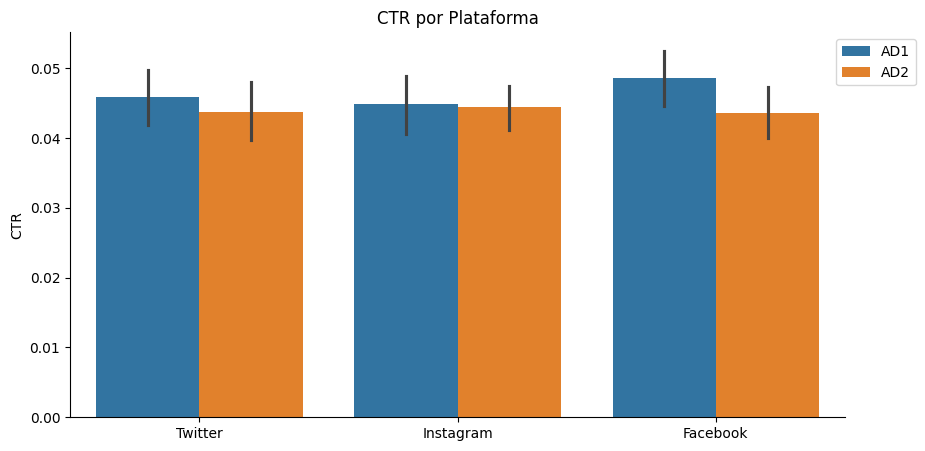

In [17]:
# Creamos un gráfico de barras para mostrar el CTR por plataforma en función del grupo de anuncios
plt.figure(figsize=(10,5))

fig2 = sns.barplot(data=df_sm,
                  x='platform',
                  y='click_through_rate',
                  hue='ad_id')

fig2.legend(loc='upper right',
           bbox_to_anchor=(1.1, 1))
fig2.spines['top'].set_visible(False)
fig2.spines['right'].set_visible(False)
fig2.set_title('CTR por Plataforma')
fig2.set_xlabel("")
fig2.set_ylabel('CTR');

A simple vista, podemos observar que el AD2 tiene un peor CTR en todas las plataformas

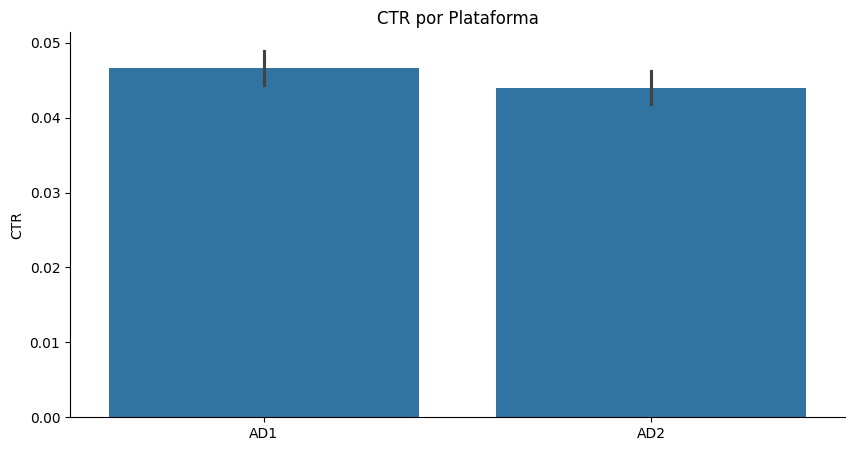

In [18]:
# Ahora mostramos el gráfico del CTR global en función del grupo de anuncios
plt.figure(figsize=(10,5))

fig2 = sns.barplot(data=df_sm,
                  x='ad_id',
                  y='click_through_rate')

fig2.spines['top'].set_visible(False)
fig2.spines['right'].set_visible(False)
fig2.set_title('CTR por Plataforma')
fig2.set_xlabel("")
fig2.set_ylabel('CTR');

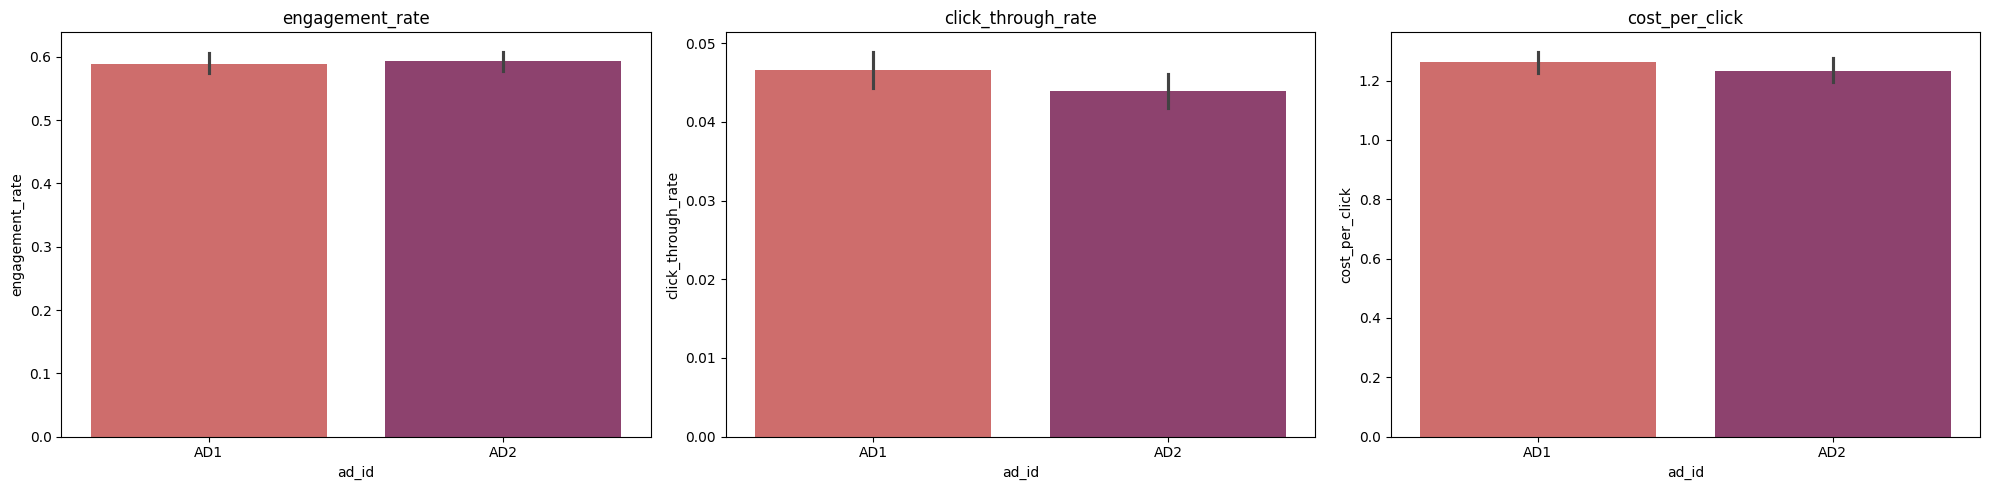

In [19]:
# Mostramos un gráfico de barras para ver las diferentes métricas según la versión del anuncio:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) # Creamos subgráficos.
columnas_graficas_2 = ["engagement_rate", "click_through_rate", "cost_per_click"] # Creamos una lista con las variables numéricas que queremos incluir en las gráficas.

for indice, columna in enumerate(columnas_graficas_2):
    sns.barplot(x="ad_id", y=columna, data=df_sm, ax=axes[indice], palette="flare") # Creamos un barplot para nuestras gráficas.
    axes[indice].set_title(columna) # Ponemos título a las gráficas.

plt.tight_layout();

## 2.4 Formulación de hipótesis

- **Efecto de la campaña AD2:** En este caso las hipótesis serían: 

    - $H0$: No hay diferencia significativa entre los grupos de anuncios 1 y 2. 

    - $H1$: Hay una diferencia significativa entre los grupos de anuncios 1 y 2.  

## 2.5 Prueba estadística

In [20]:
# Lista de métricas
metricas_sm = ["engagement_rate", "click_through_rate", "cost_per_click"]

In [21]:
# Dividimos los grupos de anuncios
grupos_sm = df_sm['ad_id'].unique()

**Prueba de normalidad (Shapiro-Wilk)**

In [22]:
# Evaluamos normalidad para cada grupo
for metrica in metricas_sm: 
    for grupo in grupos_sm: 
        print(f"Estamos analizando la variable {metrica.upper()} para el grupo de anuncios {grupo.upper()}")
        df_normalidad = df_sm[df_sm["ad_id"] == grupo]
        test_asunciones = sa.Asunciones(dataframe = df_normalidad, columna_numerica = metrica)
        test_asunciones.identificar_normalidad_analitica() # Comprobamos la asunción de normalidad, como tenemos menos de 50 datos por grupo, usaremos un shapiro test.
        print("\n-------------\n")

Estamos analizando la variable ENGAGEMENT_RATE para el grupo de anuncios AD1
Para la columna engagement_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable ENGAGEMENT_RATE para el grupo de anuncios AD2
Para la columna engagement_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable CLICK_THROUGH_RATE para el grupo de anuncios AD1
Para la columna click_through_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable CLICK_THROUGH_RATE para el grupo de anuncios AD2
Para la columna click_through_rate, los datos siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable COST_PER_CLICK para el grupo de anuncios AD1
Para la columna cost_per_click, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

---

<div style="background-color: #F74646; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Los principales resultados de los análisis de normalidad son:</h5>

1. **ENGAGEMENT_RATE**:

   - **Grupo de anuncios 1**: la variable ENGAGEMENT_RATE no sigue una distribución normal.

   - **Grupo de anuncios 2**: la variable ENGAGEMENT_RATE no sigue una distribución normal.

2. **CLICK_THROUGH_RATE**:

   - **Grupo de anuncios 1**: la variable CLICK_THROUGH_RATE no sigue una distribución normal.

   - **Grupo de anuncios 2**: la variable CLICK_THROUGH_RATE sigue una distribución normal.

3. **COST_PER_CLICK**:

   - **Grupo de anuncios 1**: la variable COST_PER_CLICK no sigue una distribución normal.

   - **Grupo de anuncios 2**: la variable COST_PER_CLICK no sigue una distribución normal.

De estos resultados podemos concluir que:

1. **CLICK_THROUGH_RATE**: dado que la variable CLICK_THROUGH_RATE sigue una distribución normal en el grupo de anuncios 2 pero no en el 1, no se cumplen las asunciones de normalidad para ambos grupos. Por tanto, no sería apropiado utilizar una prueba paramétrica.

2. **ENGAGEMENT_RATE y COST_PER_CLICK**: ambas variables no siguen una distribución normal en ninguno de los grupos de anuncios. Esto indica que las asunciones de normalidad no se cumplen y, por consiguiente, las pruebas paramétricas no serían adecuadas para analizar estas variables.


-> Dado que los datos no siguen una distribución normal, elegimos una prueba no paramétrica. En concreto, Mann Whitney U

In [23]:
# Iteramos por la lista de métricas:
for metrica in metricas_sm:
    print(f"\nEstamos analizando la métrica {metrica.upper()}")
    no_parametricos = sa.Pruebas_no_parametricas(df_sm, metrica, "ad_id") # Instanciamos la clase de los test no parámetricos.
    datos_categorias = no_parametricos.generar_grupos() # Generamos los datos para cada una de las categorías.
    no_parametricos.test_manwhitneyu(datos_categorias) # Llamamos al método para calcular el test de Mann Whitney U.


Estamos analizando la métrica ENGAGEMENT_RATE
Estadístico del Test de Mann-Whitney U: 1199.0
Valor p: 0.7277366196432564
No hay evidencia suficiente para concluir que hay una diferencia significativa.

Estamos analizando la métrica CLICK_THROUGH_RATE
Estadístico del Test de Mann-Whitney U: 1482.0
Valor p: 0.11050681166192879
No hay evidencia suficiente para concluir que hay una diferencia significativa.

Estamos analizando la métrica COST_PER_CLICK
Estadístico del Test de Mann-Whitney U: 1390.0
Valor p: 0.3362064160117333
No hay evidencia suficiente para concluir que hay una diferencia significativa.


## 2.6 Conclusiones

<div style="background-color: #F74646; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Interpretación de los resultados</h5>

- **ENGAGEMENT_RATE** --> p value: 0.728

    El p value es > 0.05, lo que indica que no hay evidencia suficiente para concluir que hay una diferencia significativa en la métrica de ENGAGEMENT_RATE entre ambos grupos de anuncios. Esto significa que el cambio implementado no ha tenido un impacto significativo. Revisando el gráfico, observamos que los valores son prácticamente idénticos.

- **CLICK_THROUGH_RATE** --> p value: 0.111

    El p value también es > 0.05. Estos resultados sugieren que el cambio implementado no ha tenido un impacto significativo en la tasa de clics. Además, observamos que dicha tasa ha disminuido, no siendo nada alentador.  

- **COST_PER_CLICK** --> p value: 0.336

    El p value es > 0.05, indicando que tampoco hay evidencia suficiente para concluir que hay una diferencia significativa en el coste por clic entre los dos grupos. Esto sugiere que el cambio implementado no ha tenido un impacto significativo. 

En base a los resultados, podemos confirmar que el grupo de anuncios 2 no ha tenido un impacto significativo respecto al grupo de anuncios 1. Por ello, podemos rechazar la hipótesis alternativa y aceptar así la hipótesis nula.

</div>

# 3. LP data

## 3.1. Lectura de los datos

In [24]:
df_lp = pd.read_csv('Datos/lp_data.csv')
df_lp.head()

,page_version,session_duration,bounce_rate,conversion_rate
0,A,248.971125,0.225584,0.051342
1,A,396.194681,0.265171,0.048562
2,A,260.315815,0.201563,0.043753
3,A,271.836058,0.205943,0.070554
4,A,282.541563,0.242047,0.052930


## 3.2. Breve exploración de los datos

In [25]:
df_lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_version      150 non-null    object 
 1   session_duration  150 non-null    float64
 2   bounce_rate       150 non-null    float64
 3   conversion_rate   150 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.8+ KB


In [26]:
sa.exploracion_dataframe(df_lp, 'page_version')

El número de datos es 150 y el de columnas es 4

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
page_version,object
session_duration,float64
bounce_rate,float64
conversion_rate,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna PAGE_VERSION tiene las siguientes valore únicos:


,count
page_version,
A,50
B,50
C,50



 ..................... 

Los principales estadísticos de las columnas categóricas para el A son: 


,count,unique,top,freq
page_version,50,1,A,50



 ..................... 

Los principales estadísticos de las columnas numéricas para el A son: 


,count,mean,std,min,25%,50%,75%,max
session_duration,50.0,307.499048,47.524589,212.228719,272.581735,303.262013,338.078873,448.973374
bounce_rate,50.0,0.293040,0.066788,0.201563,0.229705,0.277792,0.357802,0.396162
conversion_rate,50.0,0.067366,0.016247,0.040719,0.053220,0.067723,0.078152,0.098334



 ..................... 

Los principales estadísticos de las columnas categóricas para el B son: 


,count,unique,top,freq
page_version,50,1,B,50



 ..................... 

Los principales estadísticos de las columnas numéricas para el B son: 


,count,mean,std,min,25%,50%,75%,max
session_duration,50.0,321.311284,42.244470,215.154009,295.322289,323.192158,356.565564,398.928151
bounce_rate,50.0,0.271444,0.041371,0.202644,0.230954,0.272316,0.300412,0.347637
conversion_rate,50.0,0.085557,0.020910,0.050522,0.070043,0.085787,0.103646,0.118518



 ..................... 

Los principales estadísticos de las columnas categóricas para el C son: 


,count,unique,top,freq
page_version,50,1,C,50



 ..................... 

Los principales estadísticos de las columnas numéricas para el C son: 


,count,mean,std,min,25%,50%,75%,max
session_duration,50.0,295.087606,45.491190,200.594480,259.740122,303.507328,320.578653,383.649393
bounce_rate,50.0,0.293149,0.053408,0.182639,0.258497,0.285661,0.345812,0.376734
conversion_rate,50.0,0.067028,0.016129,0.034136,0.057354,0.068775,0.080341,0.088920


## 3.3. Visualización

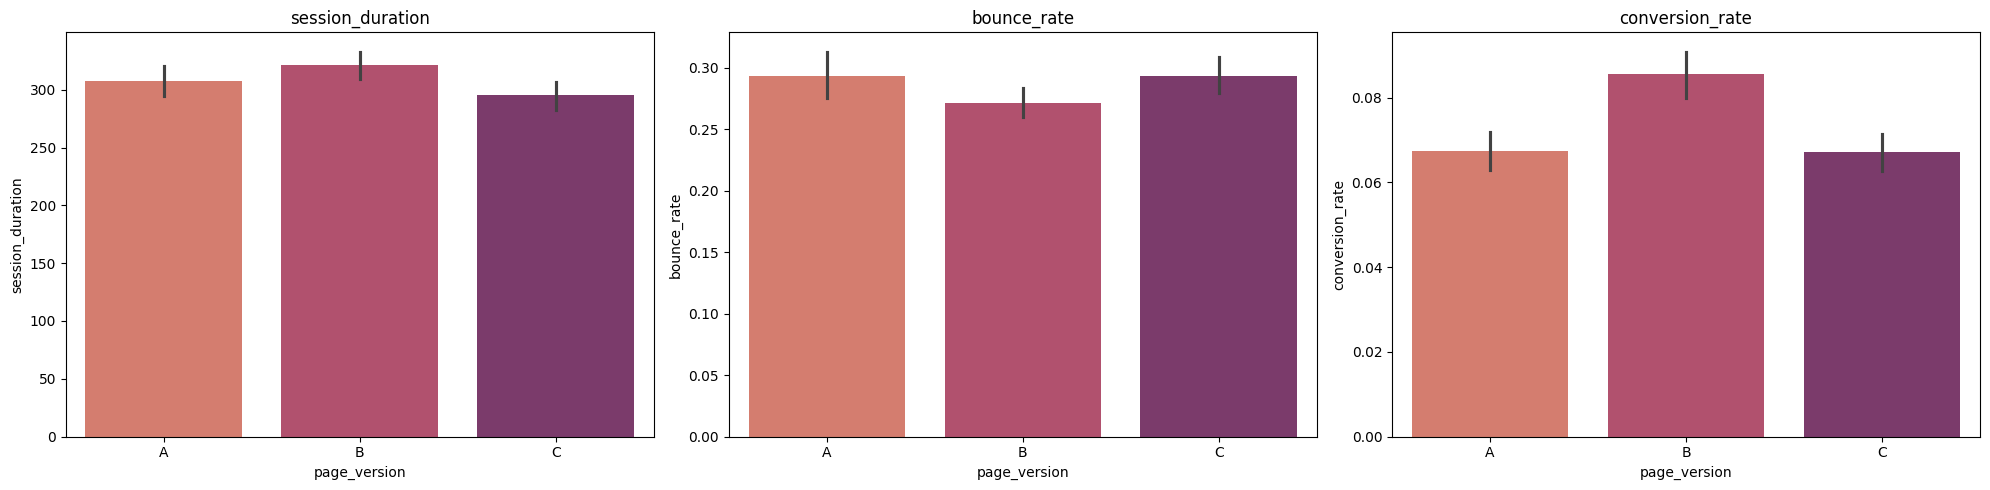

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) # Creamos subgráficos.
columnas_graficas = ["session_duration", "bounce_rate", "conversion_rate"] # Creamos una lista con las variables numéricas que queremos incluir en las gráficas.

for indice, columna in enumerate(columnas_graficas):
    sns.barplot(x="page_version", y=columna, data=df_lp, ax=axes[indice], palette="flare") # Creamos un barplot para nuestras gráficas.
    axes[indice].set_title(columna) # Ponemos título a las gráficas.

plt.tight_layout();

Una vez mostrada la información, observamos que la versión B de la página es la que mayor duración posee por sesión, menor tasa de rebote y un mayor tasa de conversión. Respecto a las otras dos versiones, A y C, ambos resultados son similares, mostrando diferencias en la duración de la sesión, la cual es más alta en la versión A.

## 3.4. Formulación de hipótesis

- **Efecto en la TASA DE CONVERSIÓN entre las diferentes páginas:** el objetivo es conocer si hay diferencias significativas en la tasa de conversión entre las diferentes páginas. En este caso las hipótesis serían: 

    - $H0$: No hay diferencias significativas en la TASA DE CONVERSIÓN entre las diferentes páginas. 

    - $H1$: Hay diferencias significativas en la TASA DE CONVERSIÓN entre las diferentes páginas.  

In [28]:
# Creamos una variable con la métrica que vamos a analizar:
metrica_lp = "conversion_rate"

In [29]:
grupos_lp = df_lp["page_version"].unique()

**Prueba de normalidad (Shapiro-Wilk)**

In [30]:
for grupo in grupos_lp: 
        print(f"Estamos analizando la variable {metrica_lp.upper()} para el grupo {grupo.upper()}")
        df_normalidad = df_lp[df_lp["page_version"] == grupo]
        test_asunciones = sa.Asunciones(dataframe = df_normalidad, columna_numerica = metrica_lp)
        test_asunciones.identificar_normalidad_analitica() # Comprobamos la asunción de normalidad, como tenemos menos de 50 datos por grupo, usaremos un shapiro test.
        print("\n-------------\n")

Estamos analizando la variable CONVERSION_RATE para el grupo A
Para la columna conversion_rate, los datos siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable CONVERSION_RATE para el grupo B
Para la columna conversion_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------

Estamos analizando la variable CONVERSION_RATE para el grupo C
Para la columna conversion_rate, los datos no siguen una distribución normal según el test de Shapiro-Wilk.

-------------



Al no cumplir con la asunción de normalidad, optamos directamente por realizar un test no paramétrico. En concreto, al tener más de dos grupos, utilizaremos el test de Kruskal-Wallis

## 3.5. Prueba Estadística

In [31]:
no_parametricos = sa.Pruebas_no_parametricas(df_lp, 'conversion_rate', 'page_version') # Instanciamos la clase de los test no parámetricos.
datos_categorias = no_parametricos.generar_grupos() # Generamos los datos para cada una de las categorías.
no_parametricos.test_kruskal(datos_categorias) # Llamamos al método para calcular el test de Kruskal.

Estadístico de prueba: 23.38848211920532
Valor p: 8.341720569259717e-06
Hay una diferencia significativa entre los datos antes y después


## 3.6. Conclusiones

<div style="background-color: #F74646; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Interpretación de los resultados</h5>

Tenemos un p valor < 0.05 indicando que si que hay diferencias entre las distintas versiones de las páginas. 

Por lo tanto, los resultados indican diferencias significativas en las diferentes versiones A, B y C.
</div>

--> Al emplear el test de Kruskal-Wallis y encontrar diferencias significativas, realizamos un test *POST HOC* no paramétrico. En este caso, la opción adecuada es Dunn's Test, que se usa para realizar comparaciones múltiples entre grupos tras una prueba no paramétrica. Dunn's Test nos va a permitir identificar qué versión de la página es la adecuada. 

In [32]:
# Creamos una variable para cada una de las tasas de conversión de cada una de las páginas
conversion_rates_A = df_lp.loc[df_lp['page_version'] == 'A', 'conversion_rate']
conversion_rates_B = df_lp.loc[df_lp['page_version'] == 'B', 'conversion_rate']
conversion_rates_C = df_lp.loc[df_lp['page_version'] == 'C', 'conversion_rate']

In [33]:
# Creamos una lista de datos agrupados para la prueba:
data = [conversion_rates_A, conversion_rates_B, conversion_rates_C]

In [34]:
# Aplicamos Dunn's Test con corrección de Bonferroni para ajustar por comparaciones múltiples
dunn_results = sp.posthoc_dunn(data, p_adjust='bonferroni')

In [35]:
# Mostramos los resultados de Dunn's Test
print("Resultados de Dunn's Test con corrección de Bonferroni:")
dunn_results

Resultados de Dunn's Test con corrección de Bonferroni:


,1,2,3
1,1.000000,0.000055,1.000000
2,0.000055,1.000000,0.000133
3,1.000000,0.000133,1.000000


In [36]:
# Creamos una lista con los nombres de los grupos:
nombres_grupos = ['Page A', 'Page B', 'Page C']

In [37]:
# Definimos alpha
alpha = 0.05

In [38]:
# Iteramos a través de la matriz de Dunn's Test para verificar si hay diferencias significativas
for i in range(len(nombres_grupos)):
    for j in range(i + 1, len(nombres_grupos)): # Sólo verificamos pares una vez.
        p_val = dunn_results.iloc[i, j] # Obtenemos el p-valor del par.
        if p_val < alpha:
            print(f"Hay diferencias significativas entre {nombres_grupos[i]} y {nombres_grupos[j]} (p = {p_val:.4f})")
        else:
            print(f"No hay diferencias significativas entre {nombres_grupos[i]} y {nombres_grupos[j]} (p = {p_val:.4f})")

Hay diferencias significativas entre Page A y Page B (p = 0.0001)
No hay diferencias significativas entre Page A y Page C (p = 1.0000)
Hay diferencias significativas entre Page B y Page C (p = 0.0001)


**Conclusión**:

Hay diferencias significativas entre las ventas de la versión de la página A y la B, así como entre la versión de la página B y C. Sin embargo, no hay diferencias significativas entre la versión de la página A y C.